In [1]:
!nvidia-smi

Sat Dec  9 01:56:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   41C    P8              10W / 230W |    991MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Necessary Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Data Processing
import numpy as np
import pandas as pd
import warnings
import pickle
import scipy.io
from sklearn.model_selection import train_test_split

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
from mpl_toolkits.mplot3d import Axes3D

# PyTorch
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import logging

# Tensorflow
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Operating System
import copy

# Las file
import lasio as las

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

2024-01-22 16:37:16.313069: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 16:37:16.313112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 16:37:16.314701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 16:37:16.489372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 16:37:17.948905: W tensorflow/compiler/

### Code Reproducibility and Logging Directory

In [3]:
pl.seed_everything(123)

Global seed set to 123


123

In [4]:
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

In [5]:
cd "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Lightning_Inventory/Volve/"

/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Lightning_Inventory/Volve


### Data Loading

In [6]:
data = pd.read_csv("/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Inputs/Volve/w319_MC_348_1.txt", delimiter="\t")

In [7]:
# summary statistics of the dataset
data.describe()

,%DEPTH,GR,RES_D,RES_S,RHOB_ORG,VP_ORG,VS_ORG,SW,DENPOR,TEMP
count,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000,4287.000000
mean,4.245254,94.156990,1.135078,1.172884,2.333651,2.656625,1.191706,0.982005,0.190642,151.440957
std,0.188625,17.320983,0.837398,0.945334,0.087190,0.176156,0.122099,0.096977,0.050932,7.159537
min,3.918661,25.744101,0.462900,0.521700,1.870000,2.134410,0.885930,0.235800,0.105900,139.044600
25%,4.081958,90.886253,0.881400,0.894800,2.308500,2.547810,1.114829,1.000000,0.158500,145.242800
50%,4.245254,98.632301,1.003500,1.022600,2.358300,2.659053,1.187358,1.000000,0.177000,151.440990
75%,4.408551,104.947200,1.147750,1.158850,2.388750,2.760677,1.265193,1.000000,0.205450,157.639100
max,4.571847,120.000000,10.645100,15.110900,2.476400,3.317078,1.852214,1.000000,0.475600,163.837300


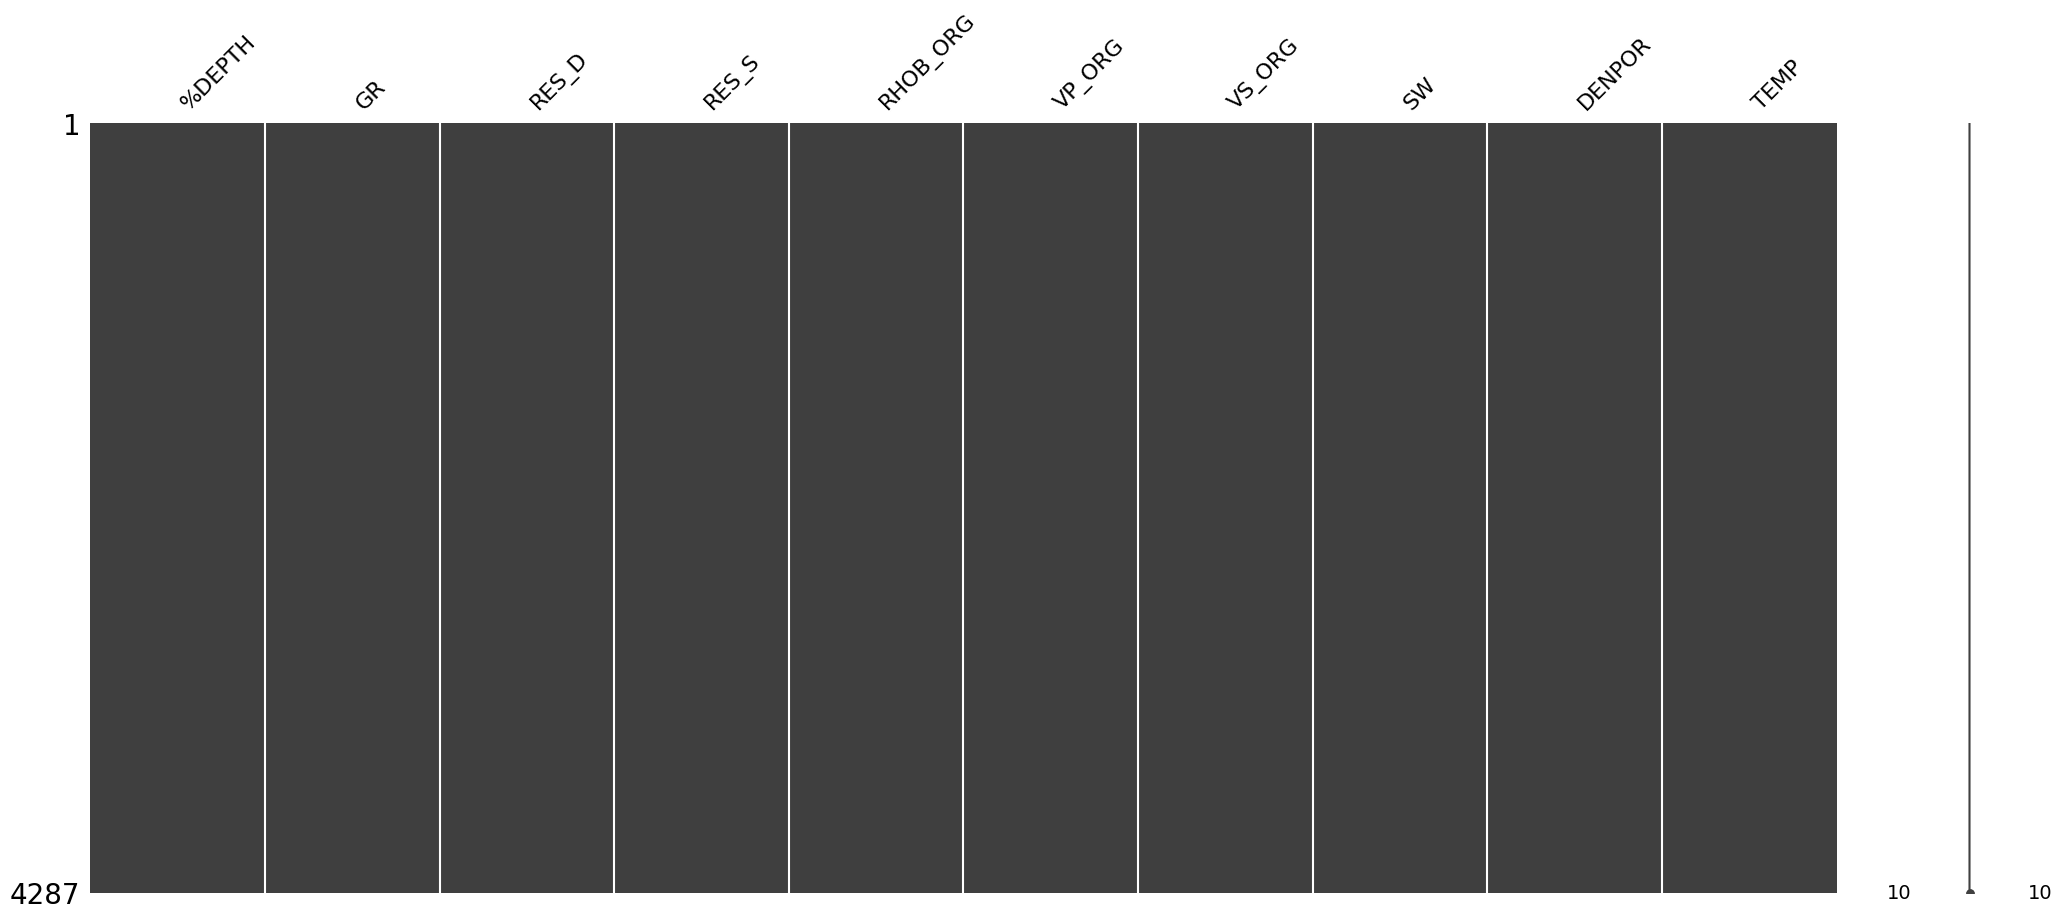

In [8]:
# Visualise the dataset to view missing points
msn.matrix(data);

In [9]:
# Creates and appends an ID sequence for the dataset
f = []
for _ in data.index:
  f.append("Volve")

data['WELL'] = f

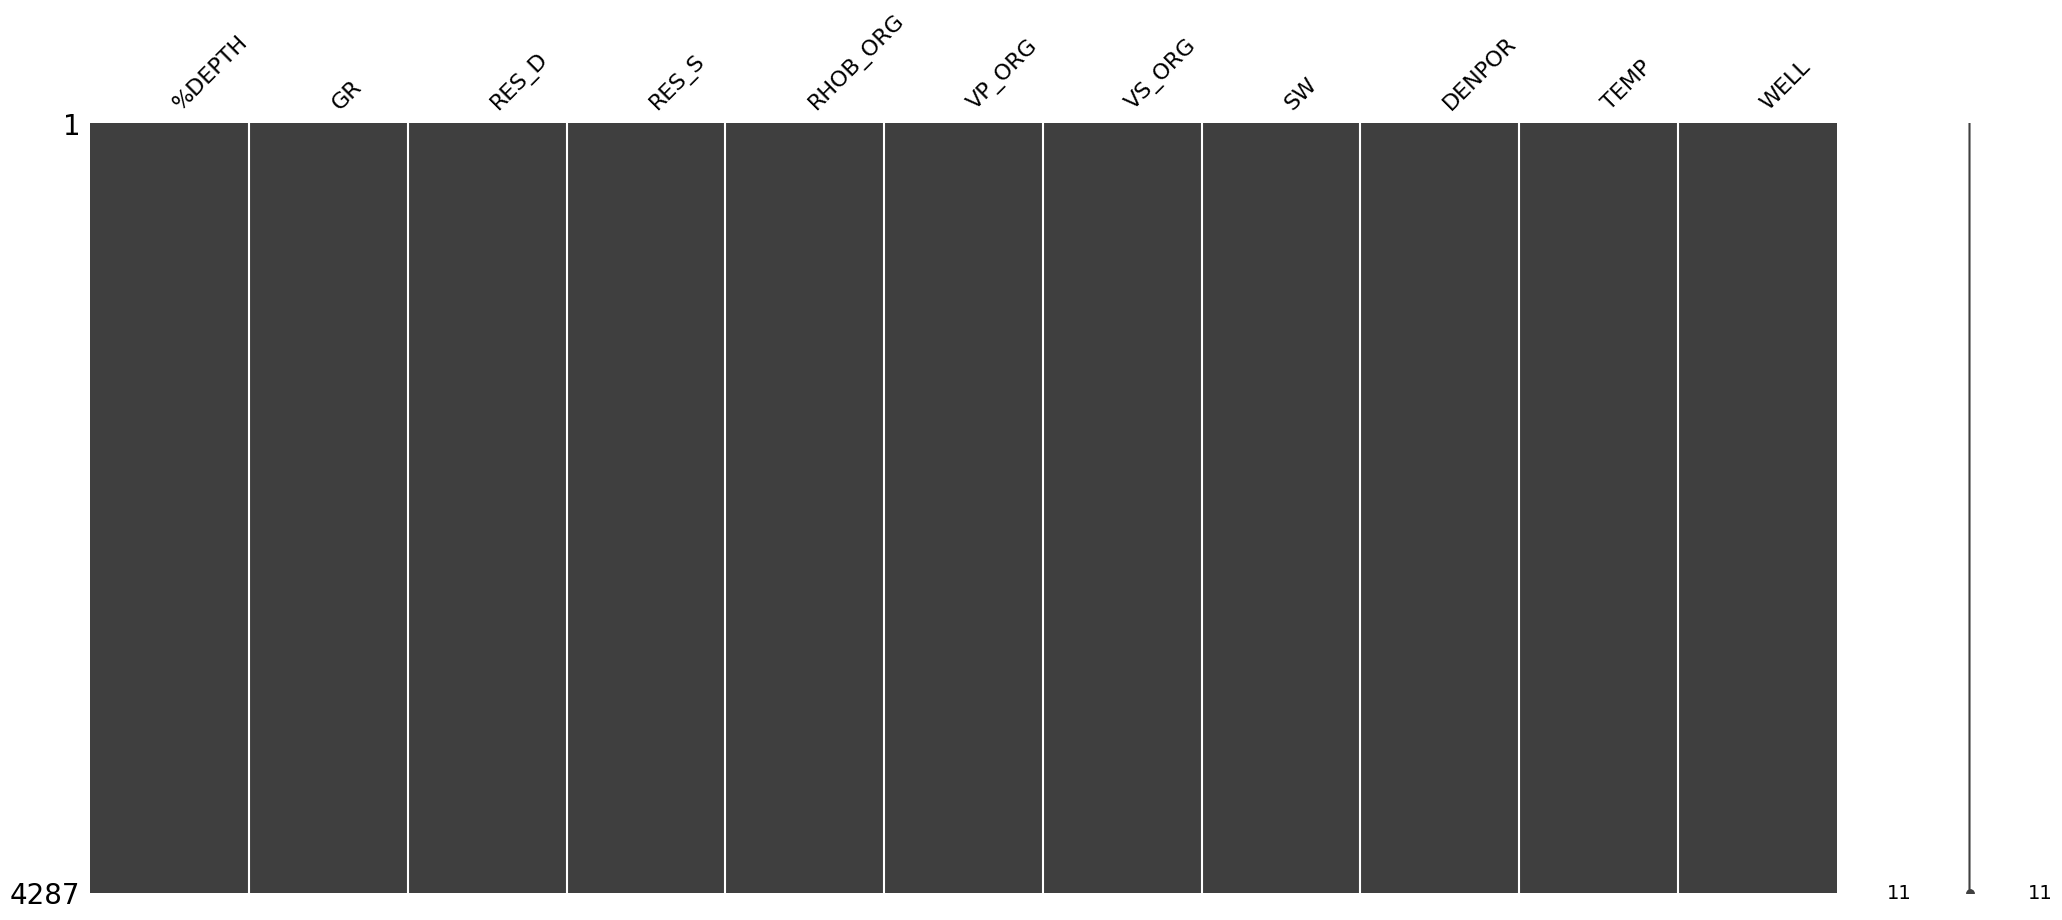

In [10]:
msn.matrix(data);

### Data Elimination

In [11]:
# helper function to replace data points with NaN
def replace_with_nan(df, col_name, seed, l=100):
    max_index = len(df) - l
    np.random.seed(seed)
    start_index = np.random.randint(0, max_index)
    df.loc[start_index:start_index+l-1, col_name] = np.nan

    return start_index

# Helper function to ensure that chosen max encoder length and prediction length are valid for the set up
def check_distance(lst, l=100):
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            if abs(lst[i] - lst[j]) < 2*l:
                return True
    return False

# Helper function to ensure that variability
def unique(start_idx,other_start_idx):
    
    list1 = list(set(start_idx))
    list2= list(set(other_start_idx))
    common_entries = [item for item in list1 if item in list2]
    decision = bool(common_entries)
    
    return decision, common_entries

def begin(start_idx):
    org_idx = sorted(start_idx)
    if org_idx[0] < 350:
        return True
    else:
        return False

In [12]:
check = True
counter = 2527 #0
target_col_elim = 50
other_col_elim = 25

while check == True:

    start_idx = []
    other_start_idx = []
    
    np.random.seed(counter)
    data_df = data.copy()
    
    for (seed_1,well) in zip((np.random.randint(0, 1000000, 8)), 
                           (["GR", "RES_D", "RES_S", "RHOB_ORG", "VP_ORG", "SW", "TEMP", "DENPOR"])):
        
        if well == "VP_ORG":
            np.random.seed(seed_1)
            rand_seeds = np.random.randint(0, 4287-target_col_elim, 14)
            for seed in rand_seeds:
                idx = replace_with_nan(data_df, well, seed, l=target_col_elim)
                start_idx.append(idx)
        else:
            np.random.seed(seed_1)
            rand_seeds = np.random.randint(0, 4287-other_col_elim-5, 15)
            for seed in rand_seeds:
                idx = replace_with_nan(data_df, well, seed, l=other_col_elim)
                other_start_idx.append(idx)
    
    check1 = check_distance(start_idx, l=50)
    check2, _ = unique(start_idx, other_start_idx)
    check3 = begin(start_idx)

    if check1 == False and check2 == False and check3 == False:
        check = False
    else:
        check = True
    counter += 1

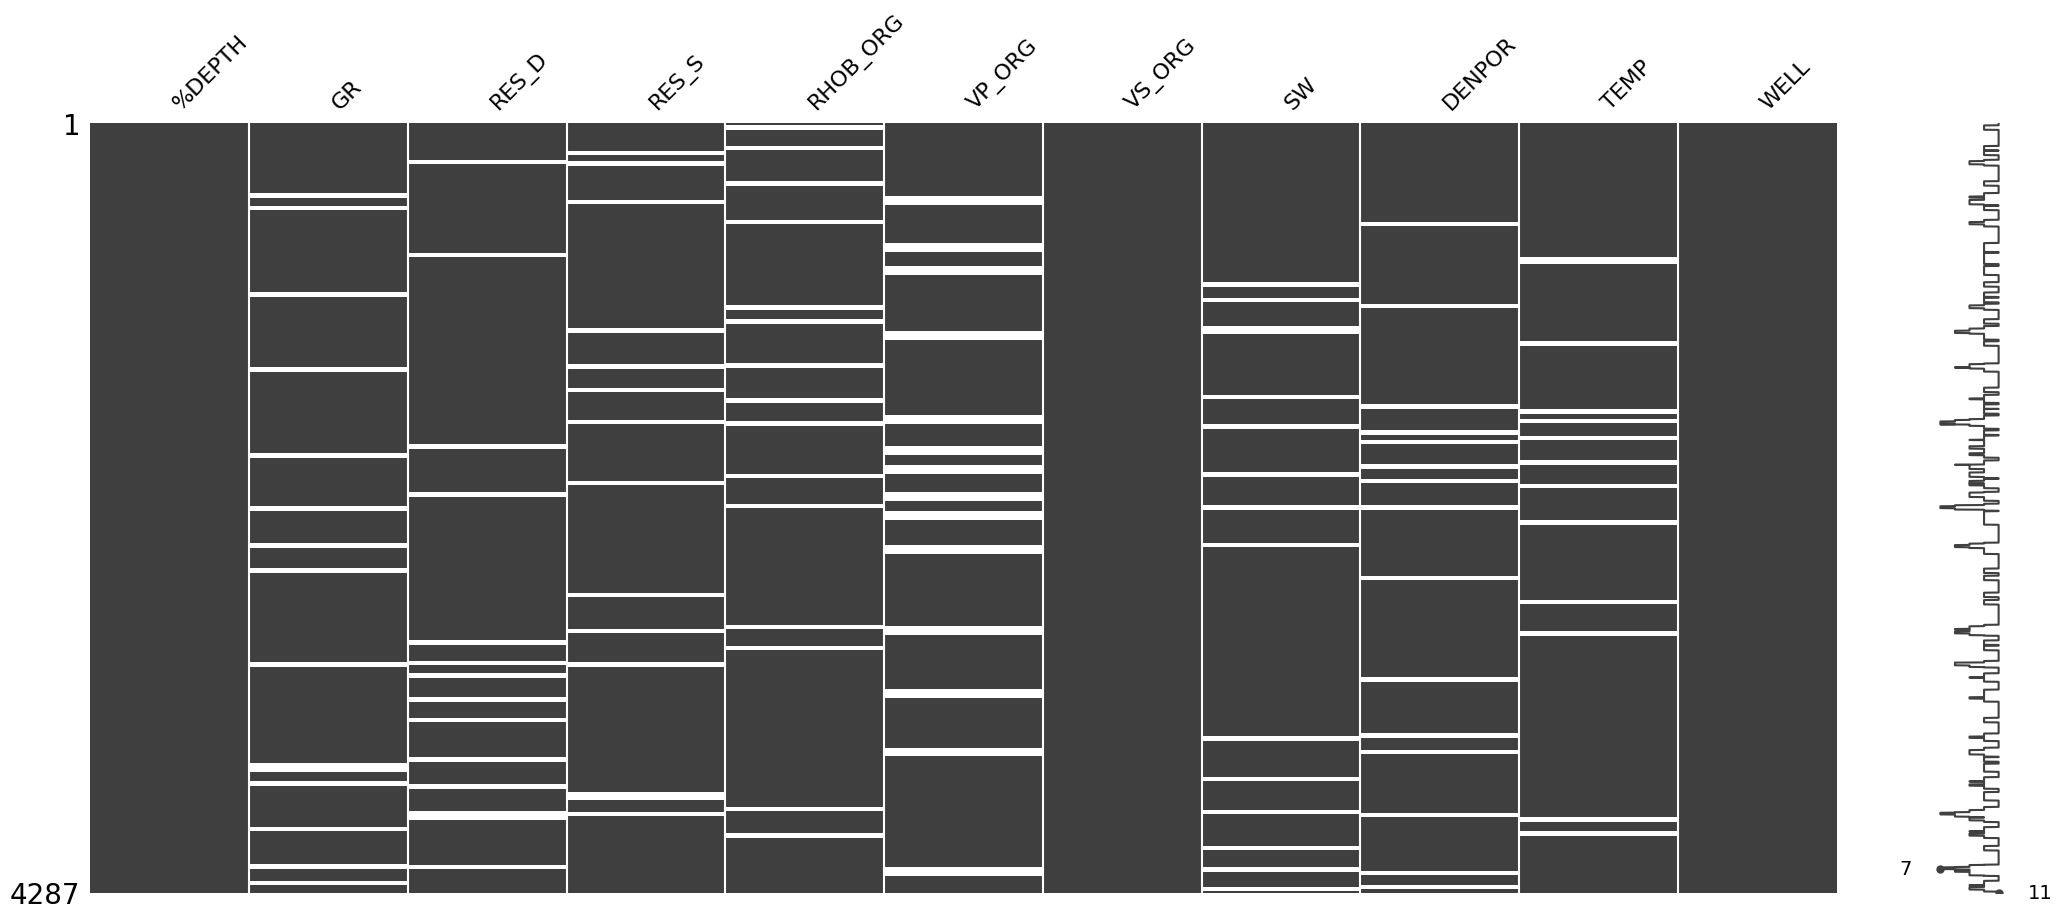

In [13]:
data_df2, data_df3 = data_df.copy(),data_df.copy() # Saves copies for later

# Visualise the dataset to view missing points
msn.matrix(data_df);

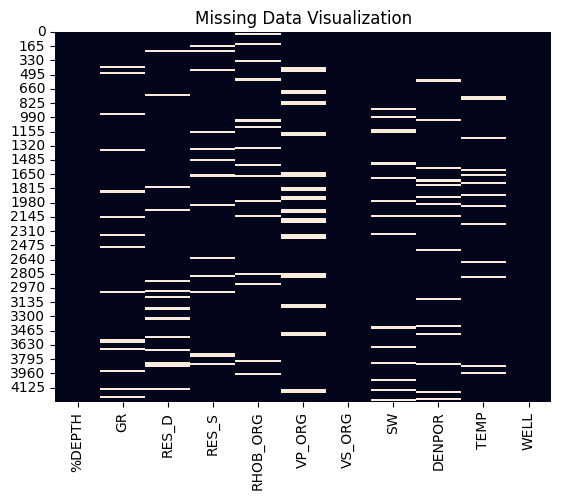

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# Visualize missing data
sns.heatmap(data_df.isnull(), cbar=False)
plt.title("Missing Data Visualization")
plt.show()

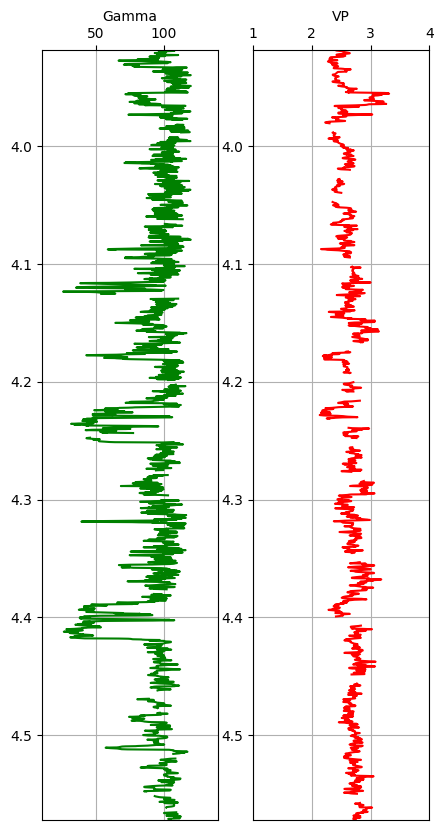

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,10)) # Create a figure and a 1x2 grid of subplots

# Plotting for ax1
ax1.plot(data_df["GR"], data_df["%DEPTH"], color="green") #, label='Data from data_df') # Plot Gamma-Ray (GR) vs Depth
#ax1.plot(data["GR"], data["%DEPTH"], color="blue",label='Data from data')
ax1.set_xlabel("Gamma") # Set x-label
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xlim(10, 140) # Set x-axis limits
ax1.set_ylim(4.571847, 3.918661) # Set y-axis limits
#ax1.invert_yaxis() # Depth tracks are typically plotted with depth increasing downwards
#ax1.legend()
ax1.grid() # Enable grid

# Plotting for ax2
ax2.plot(data_df["VP_ORG"], data_df["%DEPTH"], color="red") # Plot VP_ORG vs Depth
ax2.set_xlabel("VP") # Set x-label
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.set_xlim(1, 4) # Set x-axis limits
#ax2.semilogx() # Apply logarithmic scale to x-axis
ax2.set_ylim(4.571847, 3.918661) # Set y-axis limits
#ax2.invert_yaxis() # Depth tracks are typically plotted with depth increasing downwards
ax2.grid() # Enable grid

plt.show() # Display the plot

### Data Processing

In [16]:
# Initialize an empty list to store depth values
depth = []

# Initialize a counter variable to keep track of the depth index
counter = 0

# Iterate through the index of the DataFrame
for _ in data_df.index:
    # Append the current depth value (counter + 1) to the 'depth' list
    depth.append(counter + 1)
    # Increment the counter by 1
    counter += 1

# Print the 'depth' list (optional)
# print(depth)

# Assign the 'depth' list to the 'Depth' column of the DataFrame
data_df['Depth'] = depth
data['Depth'] = depth

In [17]:
# Creates a processed dataframe
df = data[["GR", "RES_D", "RES_S", "RHOB_ORG", "VP_ORG", "SW", "TEMP", "DENPOR", "Depth", "WELL", "%DEPTH"]]
new_dfs = {}  # Dictionary to store the new DataFrames

for index in start_idx:
    start = max(0, index - (7*target_col_elim))  
    end = min(len(df), index + target_col_elim)
    new_df = df.iloc[start:end]
    new_dfs[index] = new_df

In [18]:
# Drops the missing point from selected well log
data_df.dropna(subset=["GR", "RES_D", "RES_S", "RHOB_ORG", "VP_ORG", "SW", "TEMP", "DENPOR"], inplace=True)

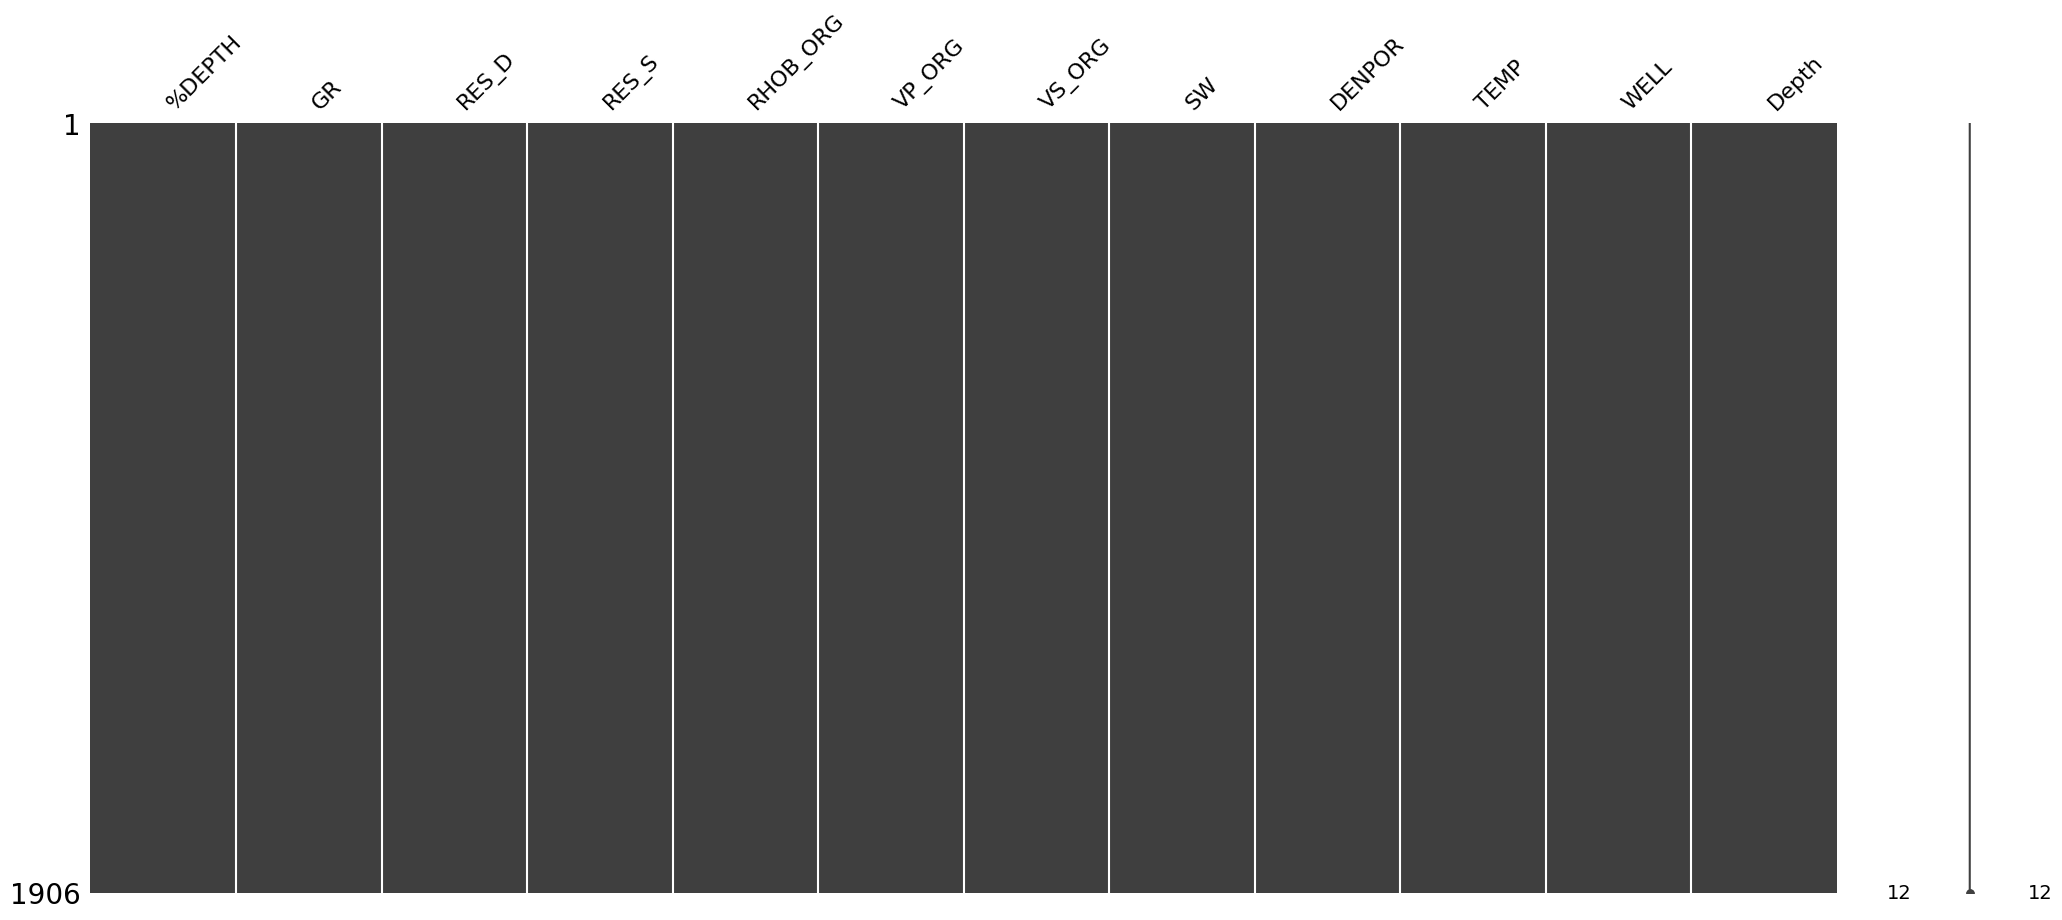

In [19]:
# Visualises the wells to ensure all misssing points have been dropped
msn.matrix(data_df);

In [20]:
data_df

,%DEPTH,GR,RES_D,RES_S,RHOB_ORG,VP_ORG,VS_ORG,SW,DENPOR,TEMP,WELL,Depth
0,3.918661,98.861198,1.0415,1.0911,2.2875,2.416397,0.967810,1.0,0.1936,139.04460,Volve,1
1,3.918814,98.237099,1.0522,1.0758,2.2953,2.413395,0.970279,1.0,0.1957,139.05040,Volve,2
2,3.918966,106.349500,1.0477,1.0760,2.2977,2.410403,0.987463,1.0,0.1969,139.05620,Volve,3
3,3.919118,100.308300,1.0327,1.0686,2.2993,2.422272,0.997590,1.0,0.1969,139.06200,Volve,4
4,3.919271,103.648100,1.0107,1.0536,2.3118,2.449444,0.992614,1.0,0.1969,139.06770,Volve,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4282,4.571238,104.741800,0.9478,0.9228,2.3336,2.728188,1.254911,1.0,0.1473,163.81419,Volve,4283
4283,4.571391,105.367800,0.9683,0.9428,2.3344,2.709584,1.246888,1.0,0.1437,163.81990,Volve,4284
4284,4.571543,105.367800,0.9752,0.9702,2.3343,2.709805,1.231183,1.0,0.1395,163.82570,Volve,4285
4285,4.571695,104.898300,0.9682,0.9984,2.3351,2.721300,1.212109,1.0,0.1359,163.83150,Volve,4286


In [21]:
# Creates a processed dataframe
train_wells = data_df[["GR", "RES_D", "RES_S", "RHOB_ORG", "VP_ORG", "SW", "TEMP", "DENPOR", "Depth", "WELL", "%DEPTH"]]

In [22]:
train_wells

,GR,RES_D,RES_S,RHOB_ORG,VP_ORG,SW,TEMP,DENPOR,Depth,WELL,%DEPTH
0,98.861198,1.0415,1.0911,2.2875,2.416397,1.0,139.04460,0.1936,1,Volve,3.918661
1,98.237099,1.0522,1.0758,2.2953,2.413395,1.0,139.05040,0.1957,2,Volve,3.918814
2,106.349500,1.0477,1.0760,2.2977,2.410403,1.0,139.05620,0.1969,3,Volve,3.918966
3,100.308300,1.0327,1.0686,2.2993,2.422272,1.0,139.06200,0.1969,4,Volve,3.919118
4,103.648100,1.0107,1.0536,2.3118,2.449444,1.0,139.06770,0.1969,5,Volve,3.919271
...,...,...,...,...,...,...,...,...,...,...,...
4282,104.741800,0.9478,0.9228,2.3336,2.728188,1.0,163.81419,0.1473,4283,Volve,4.571238
4283,105.367800,0.9683,0.9428,2.3344,2.709584,1.0,163.81990,0.1437,4284,Volve,4.571391
4284,105.367800,0.9752,0.9702,2.3343,2.709805,1.0,163.82570,0.1395,4285,Volve,4.571543
4285,104.898300,0.9682,0.9984,2.3351,2.721300,1.0,163.83150,0.1359,4286,Volve,4.571695


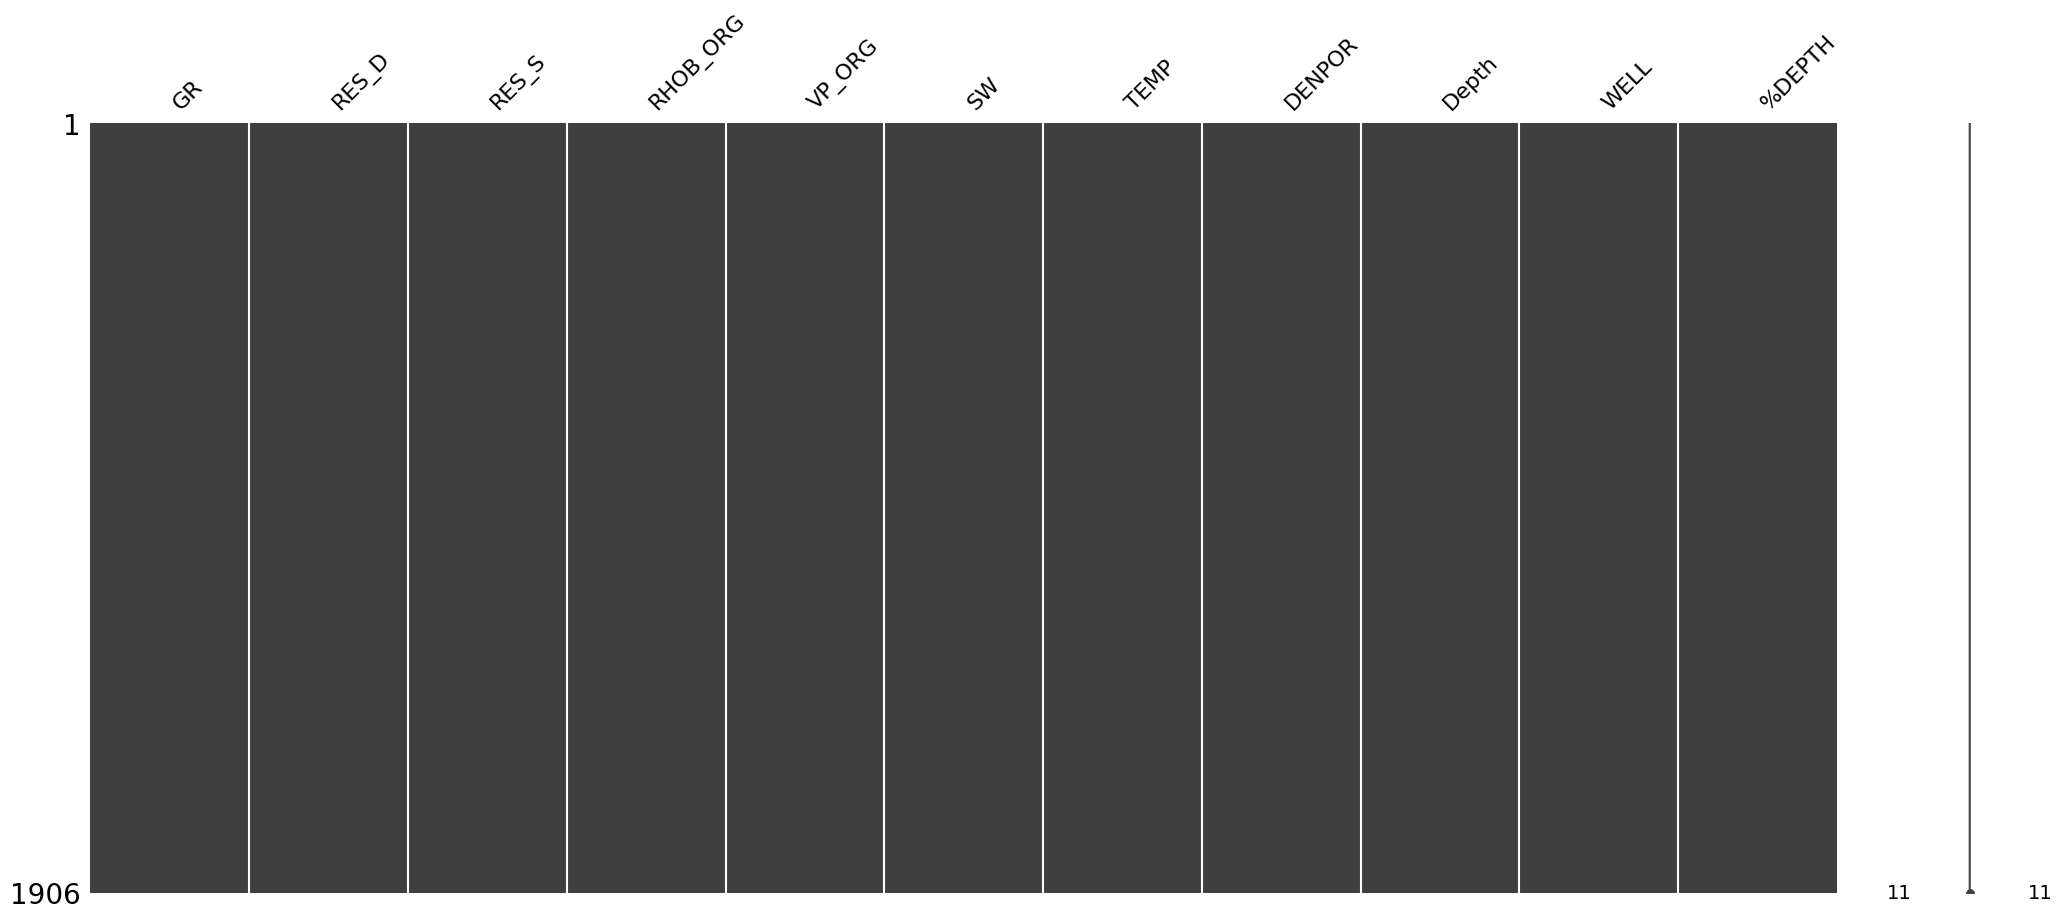

In [23]:
msn.matrix(train_wells);

In [24]:
# Checks for missing datapoints in each individual log["GR", "RES_D", "RES_S", "RHOB_ORG", "VP_ORG", "SW", "TEMP", "DENPOR"]
print(train_wells['RES_D'].isna().any(), 
      train_wells['GR'].isna().any(),
      train_wells['RES_S'].isna().any(),
      train_wells['RHOB_ORG'].isna().any(),
      train_wells['VP_ORG'].isna().any(),
      train_wells['SW'].isna().any(),
      train_wells['TEMP'].isna().any(),
      train_wells['DENPOR'].isna().any())

False False False False False False False False


# Temporal Fusion Transformers

### Hyperparameters

In [25]:
# Initial hyperparameters
batch_size = 20
heads = 6
hidden_sizes = 480
learning_rate = 0.001
gradient_clipping = 0.1
max_prediction_length = target_col_elim
max_encoder_length = 7*target_col_elim
max_epoch = 250
drop_out = 0.1
lstm_layers = 4

### TFT Dataloader

In [26]:
# Create a TimeSeriesDataSet for training data
training = TimeSeriesDataSet(
    train_wells,  # Training data
    time_idx="Depth",  # Time index column
    target="VP_ORG",  # Target column
    group_ids=['WELL'],  # Group IDs if any
    min_encoder_length=max_encoder_length // 2,  # Minimum encoder length
    max_encoder_length=max_encoder_length,  # Maximum encoder length
    min_prediction_length=20,  # Minimum prediction length
    max_prediction_length=max_prediction_length,  # Maximum prediction length
    static_categoricals=['WELL'],  # Static categorical features if any
    time_varying_known_reals=["GR", "RES_D", "RES_S", "RHOB_ORG", "SW", "TEMP", "DENPOR", "%DEPTH"],  # Time-varying known real features if any
    time_varying_unknown_reals=['VP_ORG'],  # Time-varying unknown real features
    add_relative_time_idx=True,  # Add relative time index
    add_encoder_length=True,  # Add encoder length
    allow_missing_timesteps=True, # Accommodates potential missing timesteps
    categorical_encoders={'WELL': NaNLabelEncoder(add_nan=True)}
)

In [27]:
# Create a validation dataset 
validation = TimeSeriesDataSet.from_dataset(training, train_wells, predict=True, stop_randomization=True)


# Create a dataloader
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32)

In [28]:
testing_datasets = []
test_dataloaders = []
org_start_idx = sorted(start_idx)

for idx in range(len(start_idx)):
    # Create testing dataset from each dataframe
    try:
        testing_dataset = TimeSeriesDataSet.from_dataset(training, new_dfs[org_start_idx[idx]], predict=True, stop_randomization=True)
        testing_datasets.append(testing_dataset)
        
        # Create dataloader for each testing dataset
        test_dataloader = testing_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=32)
        test_dataloaders.append(test_dataloader)
    except:
        print(f"Testing Dataset with index {idx} did not compute")
        pass

In [29]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,1,4287,1,0,1,4287,0,257,390
1,1,4287,1,1,2,4287,0,257,389
2,1,4287,1,2,3,4287,0,257,388
3,1,4287,1,3,4,4287,0,257,387
4,1,4287,1,4,5,4287,0,257,386
...,...,...,...,...,...,...,...,...,...
2881,1,4287,1,1719,3892,4287,0,1900,391
2882,1,4287,1,1719,3892,4287,0,1901,392
2883,1,4287,1,1719,3892,4287,0,1902,393
2884,1,4287,1,1719,3892,4287,0,1903,394


In [30]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
1719,1,4287,1,1719,3892,4287,0,1905,396


In [31]:
testing_datasets[3].index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,807,1206,1,0,807,400,0,399,400


### TFT Model

In [32]:
# Defines a custom class call back to retrieve loss values

class MetricsCallback(pl.Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_epoch_end(self, trainer, pl_module):
        metric = copy.deepcopy(trainer.callback_metrics)
        self.metrics.append(metric)

In [33]:
# Instantiates the class
metrics_callback = MetricsCallback()

In [34]:
warnings.filterwarnings("ignore")

# Define the Early Stopping callback
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-5,
    patience=10,
    verbose=True,
    mode="min"
)

# Define the Learning Rate Monitor callback
lr_logger = LearningRateMonitor()

# Define the TensorBoard Logger
logger = TensorBoardLogger("lightning_logs")

# Define the Trainer configuration
trainer = pl.Trainer(
    max_epochs=max_epoch,
    accelerator='gpu',  # Use GPU acceleration
    devices=1,  # Number of GPUs to use
    enable_model_summary=True,  # Enable model summary
    gradient_clip_val=gradient_clipping,  # Gradient clipping value
    callbacks=[lr_logger, early_stop_callback, metrics_callback],  # Callbacks to use during training
    logger=logger  # Logger for tracking training progress
)

# Create the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_sizes,
    attention_head_size=heads,
    dropout=drop_out,
    lstm_layers = lstm_layers,
    hidden_continuous_size=hidden_sizes,
    output_size=7,  # Number of quantiles (default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
    loss=QuantileLoss(),  # Loss function to use
    log_interval=10,  # Logging interval
    reduce_on_plateau_patience=4  # Patience for reducing learning rate on plateau
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Model Training

In [35]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2     
3  | prescalers                         | ModuleDict                      | 10.6 K
4  | static_variable_selection          | VariableSelectionNetwork        | 927 K 
5  | encoder_variable_selection         | VariableSelec

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.133


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.086 >= min_delta = 1e-05. New best score: 0.047


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 1e-05. New best score: 0.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.008


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.007


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.006


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.003


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.003


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.002


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.002


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.002


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.002


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.002


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


In [36]:
train_loss = []
validation_loss = []
for index in range(len(metrics_callback.metrics)):
  try:
    train_loss.append(float(metrics_callback.metrics[index]['train_loss']))
    validation_loss.append(float(metrics_callback.metrics[index]['val_loss']))

  except:
    pass

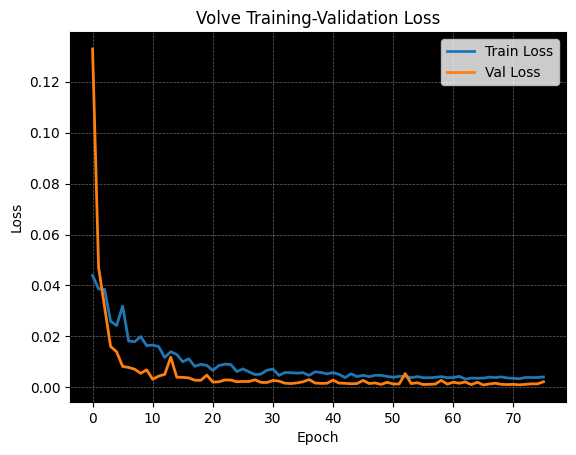

In [37]:
# Create a new figure with a dark background
fig, ax = plt.subplots()
fig.set_facecolor('white')
ax.set_facecolor('black')

plt.plot(train_loss, linewidth=2, label= "Train Loss");
plt.plot(validation_loss, linewidth=2, label = "Val Loss")

# Add labels to x-axis and y-axis (customize as needed)
ax.set_xlabel("Epoch", color='black')
ax.set_ylabel("Loss", color='black')

# Customize other plot properties (title, grid, etc.)
ax.set_title("Volve Training-Validation Loss", color='black', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Customize tick labels and colors
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.legend(loc="upper right")

plt.savefig("/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Volve/Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure


# Show the plot
plt.show()

In [38]:
warnings.filterwarnings("ignore")
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path) #loads the model

lightning_logs/lightning_logs/version_4/checkpoints/epoch=75-step=10640.ckpt


In [54]:
#zip and download the model
!zip  -r '/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Volve.zip' lightning_logs/lightning_logs/version_4/*

  adding: lightning_logs/lightning_logs/version_4/10640/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_4/10640/WELL/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_4/10640/WELL/tensors.tsv (stored 0%)
  adding: lightning_logs/lightning_logs/version_4/10640/WELL/metadata.tsv (stored 0%)
  adding: lightning_logs/lightning_logs/version_4/checkpoints/ (stored 0%)
  adding: lightning_logs/lightning_logs/version_4/checkpoints/epoch=75-step=10640.ckpt (deflated 8%)
  adding: lightning_logs/lightning_logs/version_4/events.out.tfevents.1702076269.76-2223-03.62325.0 (deflated 11%)
  adding: lightning_logs/lightning_logs/version_4/events.out.tfevents.1702087468.76-2223-03.62325.2 (deflated 11%)
  adding: lightning_logs/lightning_logs/version_4/hparams.yaml (deflated 91%)
  adding: lightning_logs/lightning_logs/version_4/projector_config.pbtxt (deflated 35%)


In [67]:
#load our saved model again
!unzip -o '/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Athabasca_Welllog_[Volve].zip'
best_model_path='lightning_logs/lightning_logs/version_1/checkpoints/epoch=71-step=2016.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Archive:  /home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Models/Athabasca_Welllog_[Volve].zip
 extracting: lightning_logs/lightning_logs/version_1/02016/WELL/tensors.tsv  
 extracting: lightning_logs/lightning_logs/version_1/02016/WELL/metadata.tsv  
  inflating: lightning_logs/lightning_logs/version_1/checkpoints/epoch=71-step=2016.ckpt  
  inflating: lightning_logs/lightning_logs/version_1/events.out.tfevents.1701588819.76-2223-03.2763190.0  
  inflating: lightning_logs/lightning_logs/version_1/events.out.tfevents.1701604346.76-2223-03.2763190.2  
  inflating: lightning_logs/lightning_logs/version_1/hparams.yaml  
  inflating: lightning_logs/lightning_logs/version_1/projector_config.pbtxt  


/home/g202216220/miniconda3/envs/forecasting/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/g202216220/miniconda3/envs/forecasting/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


### Validation Evaluation

In [39]:
warnings.filterwarnings("ignore")

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader,trainer_kwargs=dict(accelerator="cpu"))

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

0.004712157417088747
tensor([0.0047])


In [40]:
warnings.filterwarnings("ignore")
trainer.test(best_tft,val_dataloader);

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MAE          │   0.004712071269750595    │
│         test_MAPE         │   0.0015733656473457813   │
│         test_RMSE         │   0.0049229334108531475   │
│        test_SMAPE         │   0.0015720349038019776   │
│         test_loss         │   0.0022086098324507475   │
└───────────────────────────┴───────────────────────────┘

In [41]:
def pred_plot_df(well_name, well=train_wells, pred_data=validation, tft_model=best_tft, accelerator="cpu"):

    # Creates a dataframe containing just the selected well
    well_df  = well[well["WELL"] == well_name]

    # Creates the new index for the observed values and values to be predicted: Uses 160 because the encoder length is set to 140, plus the max_prediction of 20 totals 160
    values = well_df["%DEPTH"].tolist()
    observed_idx = values[-400:]
    pred_idx = values[-50:]

    # Prepares the observed data for plotting
    new_well_df = well_df.iloc[-400:].copy()
    new_well_df["Depth index"] = observed_idx
    new_well_df.set_index("Depth index", inplace=True)

    # Conducts the prediction 
    single_pred =best_tft.predict(pred_data.filter(lambda x: (x.WELL == well_name)),
                                  mode="raw",
                                  trainer_kwargs=dict(accelerator=accelerator), 
                                  return_x=True, 
                                  return_y=True)

    # Retrieves the predicted output and converts to dataframe for plotting 
    pred_data = single_pred.output.prediction[:, :, 4][0]  # [:, :, 4] 4 was used because we're interested in the 50th quantile
    pred_df = pd.DataFrame(pred_data.numpy())
    pred_df["pred_index"] = pred_idx
    pred_df.set_index("pred_index", inplace=True)
    pred_df

    return new_well_df, pred_df, pred_idx

In [42]:
# Gets the number of unique wells
train_wells_len = len(train_wells['WELL'].unique())
print(train_wells_len)

# Retrieves a list of the well names
well_names_list = train_wells['WELL'].unique()
#well_names_list[12]

1


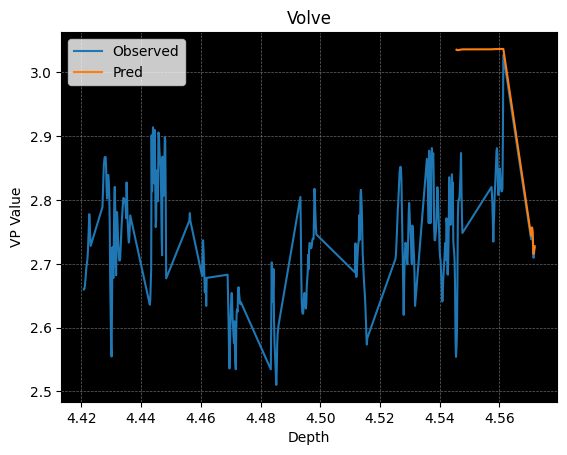

In [53]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightning")
for well_name in well_names_list:
    X, Y,_ = pred_plot_df(well_name)
    
    # Create a new figure for each plot
    fig, ax = plt.subplots()
    
    # Plot the data on the axes
    ax.plot(X['VP_ORG'], label="Observed")
    ax.plot(Y, label="Pred")

    fig.set_facecolor('white')
    
    # Set the background color of the figure
    ax.set_facecolor('black')  # 
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
    
    # Customize the plot title and legend
    ax.set_title(f"{well_name}")
    ax.legend()

    # Add labels to x-axis and y-axis
    ax.set_xlabel("Depth")  
    ax.set_ylabel("VP Value")  

    # Define the directory where you want to save the files
    save_directory = "/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Volve/Validation/"

    # Create the directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    
    s_well_name = well_name.replace('/', '_')

    # Generate the file name based on the well_name
    file_name = os.path.join(save_directory, f"validation-{s_well_name}.pdf")

    # Save the figure with the unique file name
    plt.savefig(file_name, format="pdf", bbox_inches="tight")

    # Show the plot
    plt.show()
warnings.resetwarnings()

In [44]:
warnings.filterwarnings("ignore")
# Compares the prediction against the actual for the entire validation dataset
predictions = best_tft.predict(val_dataloader, return_x=True,trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
#best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

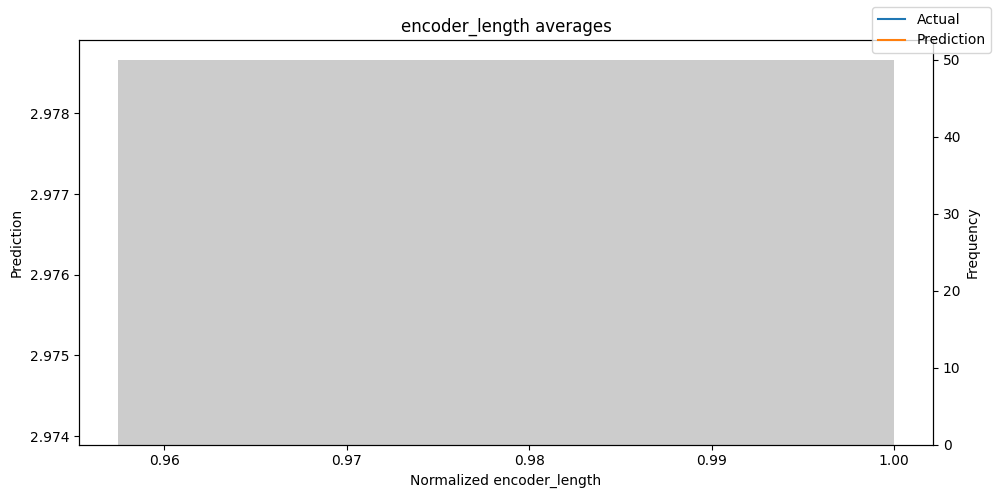

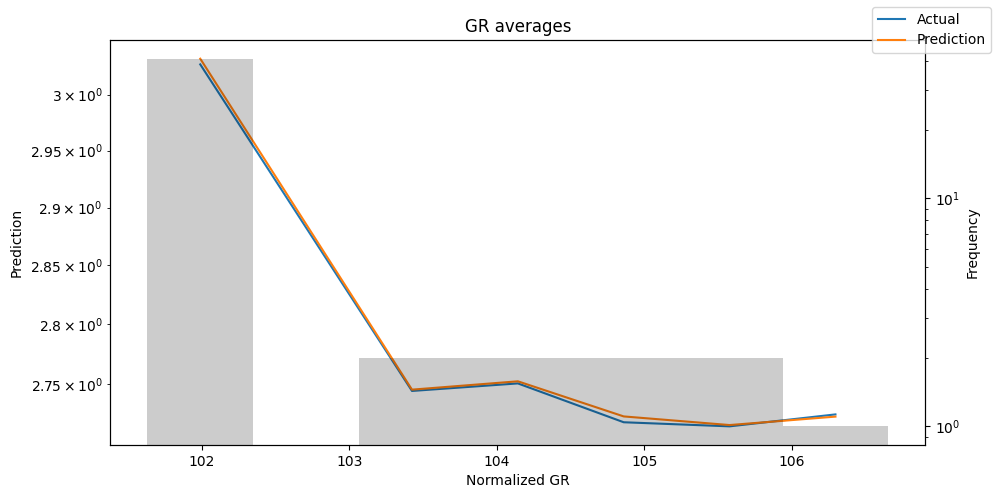

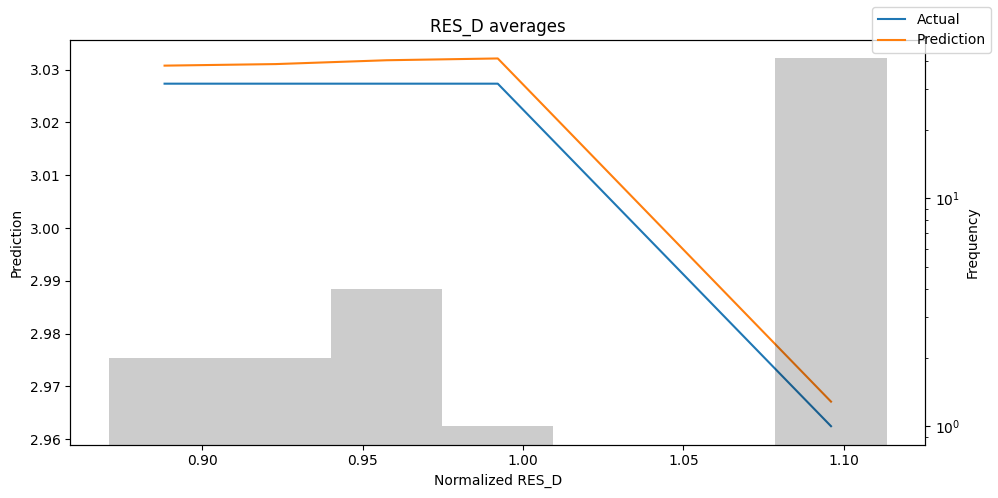

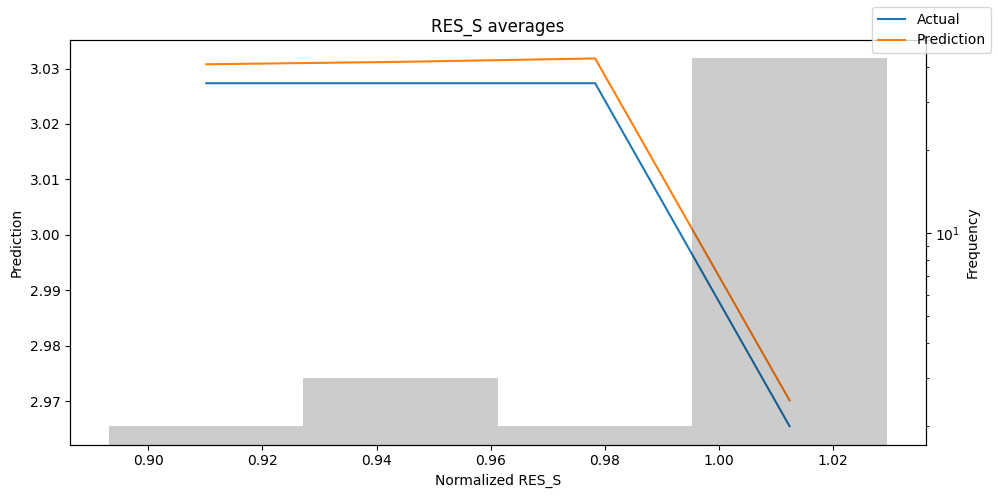

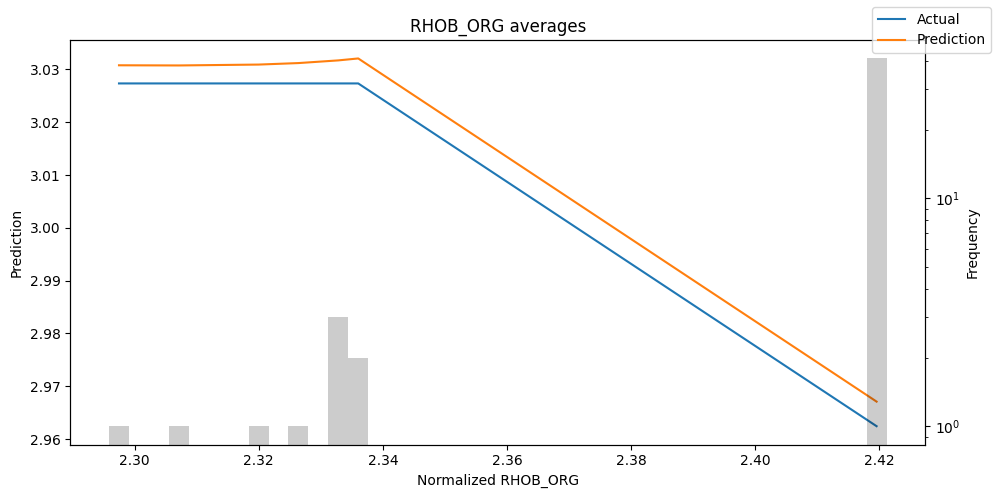

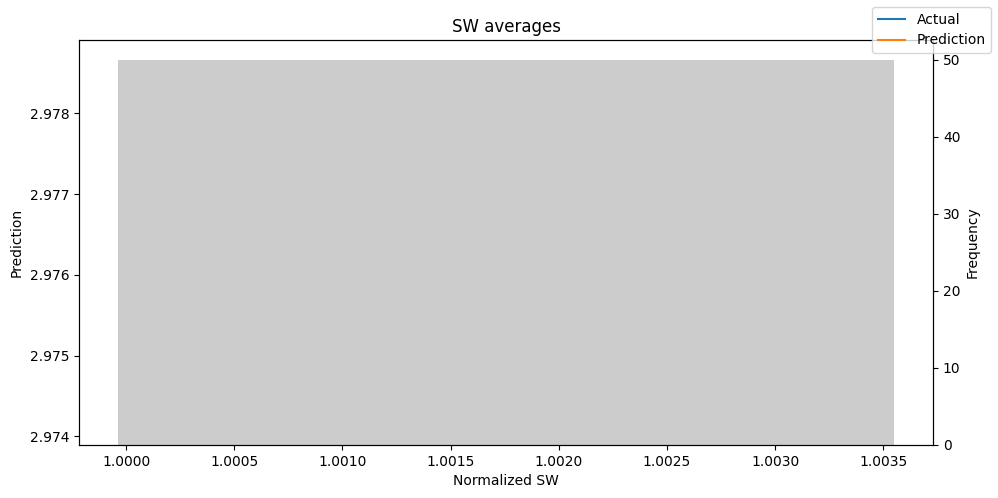

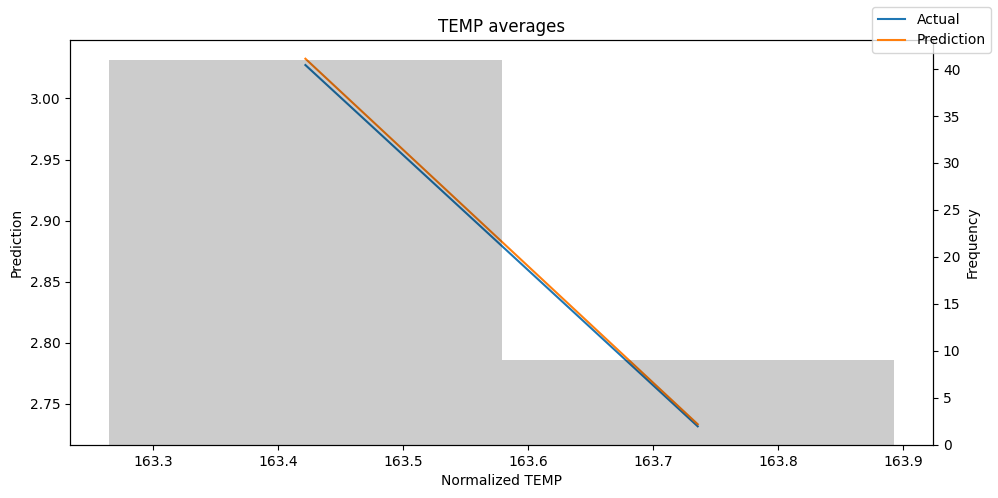

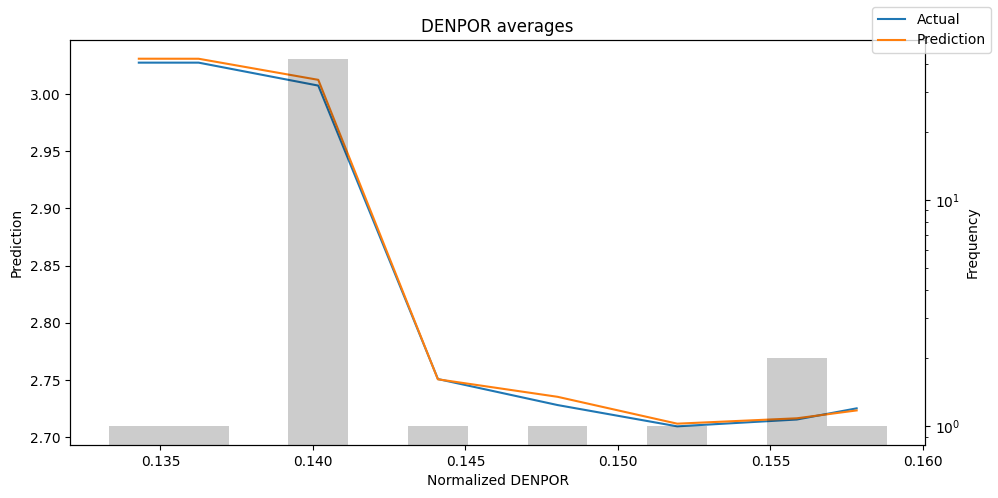

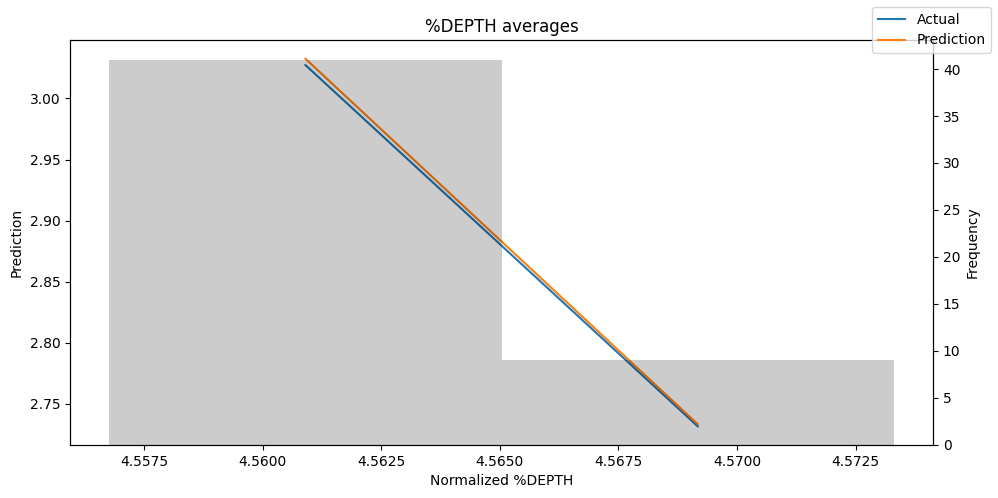

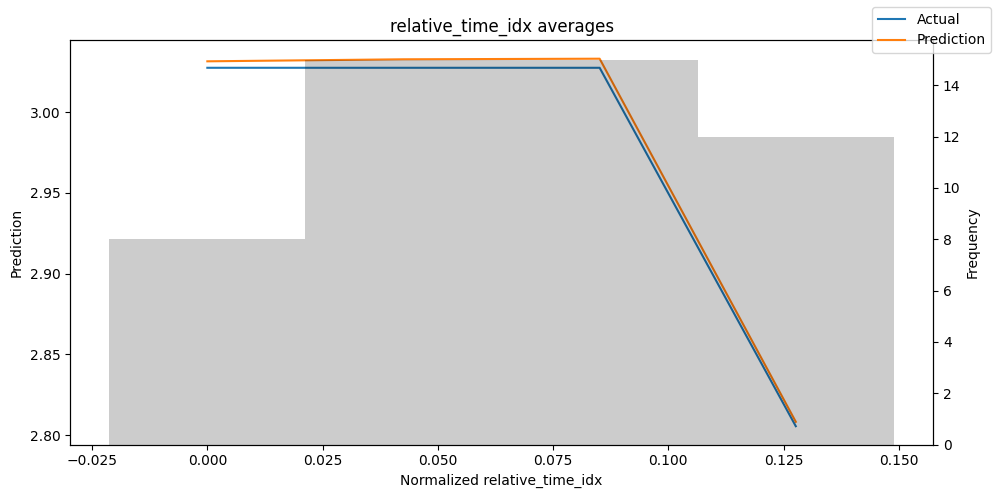

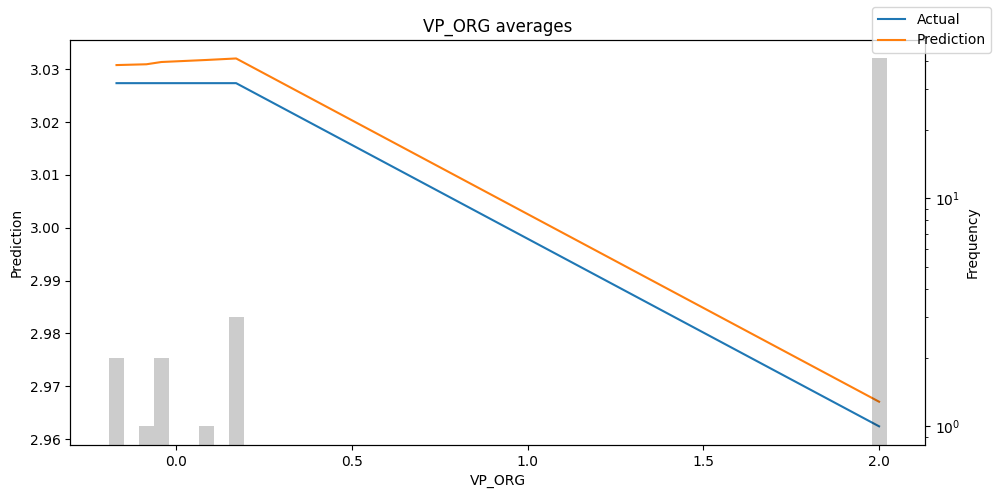

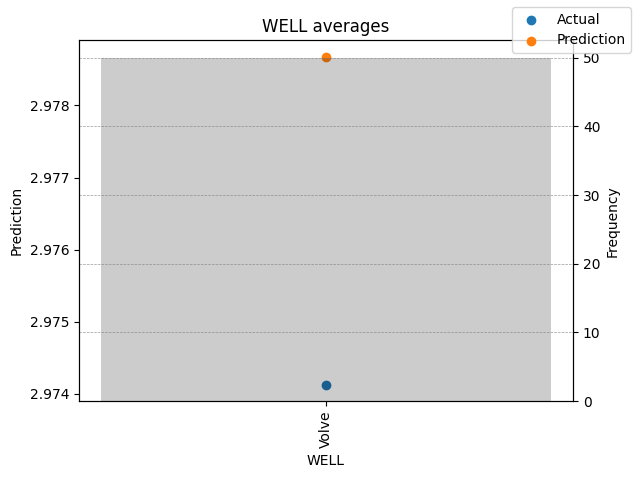

In [45]:
# Plot the data using the method provided by best_tft
fig = best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

# Show the plot
plt.show()


### Real World Application

In [46]:
comp_idx = []
for idx in org_start_idx:
    #print(idx)
    for i in range(target_col_elim):
        temp_idx = idx + i
        comp_idx.append(temp_idx)

In [47]:
pred_values = []

for idx in range(len(testing_datasets)):
# Conducts the prediction 
    warnings.filterwarnings("ignore")
    single_pred =best_tft.predict(testing_datasets[idx].filter(lambda x: (x.WELL == "Volve")),
                                  mode="raw",
                                  trainer_kwargs=dict(accelerator="cpu"), 
                                  return_x=True, 
                                  return_y=True)
    
    # Retrieves the predicted output and converts to dataframe for plotting 
    pred_data = single_pred.output.prediction[:, :, 4][0]  # [:, :, 4] 4 was used because we're interested in the 50th quantile
    pred_values.extend(pred_data.tolist())

In [48]:
# Checks for NaN before filling
data_df3['VP_ORG'].isna().any()

True

In [49]:
# Replacing NaN values at specific indices
for index, value in zip(comp_idx, pred_values):
    data_df3.at[index, 'VP_ORG'] = value

In [50]:
# Checks for NaN afterwards
data_df3['VP_ORG'].isna().any()

False

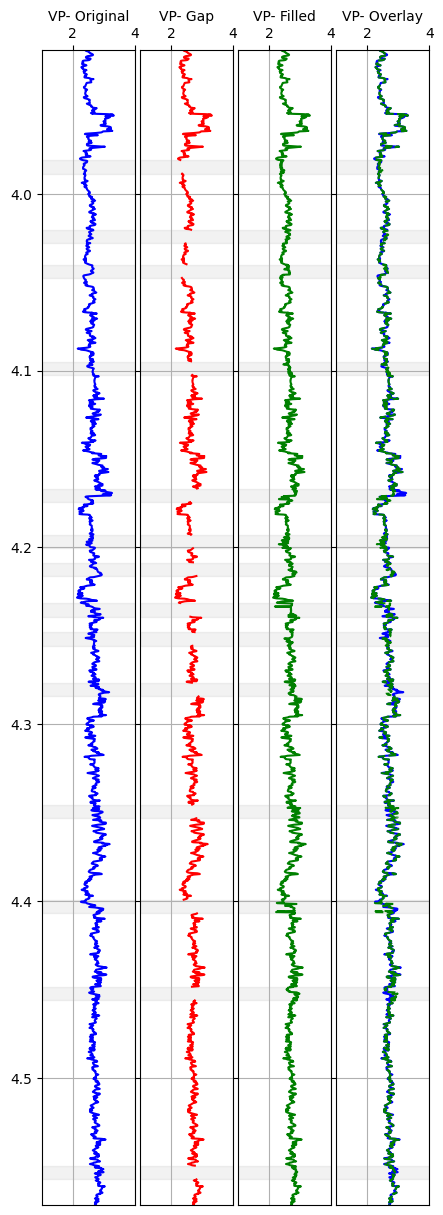

In [69]:
# Define the index_to_depth function
def index_to_depth(index, data_frame):
    return data['%DEPTH'].iloc[index]

# Starting indices of NaN sections and their length
nan_start_indices = org_start_idx
nan_section_length = 50

# Create a figure and a 1x4 grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(5, 15)) #, sharey=True)
ax1, ax2, ax3, ax4 = axes
#fig, axes = plt.subplots(1, 4, figsize=(5, 15)) # Create a figure and a 1x4 grid of subplots
#ax1, ax2, ax3, ax4 = axes

fig.set_facecolor('white')

# Set the background color of the figure
#axes.set_facecolor('white') 


# Plotting for ax1 - Original Data
ax1.plot(data["VP_ORG"], data["%DEPTH"], color="blue")
ax1.set_xlabel("VP- Original")
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.set_xlim(1, 4)
ax1.set_ylim(4.571847, 3.918661)
ax1.grid()
ax1.set_facecolor('white') 

# Plotting for ax2 - Data with Gap
ax2.plot(data_df2["VP_ORG"], data_df2["%DEPTH"], color="red")
ax2.set_xlabel("VP- Gap")
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.set_xlim(1, 4)
ax2.set_ylim(4.571847, 3.918661)
ax2.grid()
ax2.set_facecolor('white') 
plt.setp(ax2.get_yticklabels(), visible=False)  # Hide y-axis labels

# Plotting for ax3 - Data Filled
ax3.plot(data_df3["VP_ORG"], data_df3["%DEPTH"], color="green")
ax3.set_xlabel("VP- Filled")
ax3.xaxis.set_label_position('top')
ax3.xaxis.tick_top()
ax3.set_xlim(1, 4)
ax3.set_ylim(4.571847, 3.918661)
ax3.grid()
ax3.set_facecolor('white') 
plt.setp(ax3.get_yticklabels(), visible=False)  # Hide y-axis labels

# Plotting for ax4 - Overlay of Original and Filled
ax4.plot(data["VP_ORG"], data["%DEPTH"], color="blue", label='Original')
ax4.plot(data_df3["VP_ORG"], data_df3["%DEPTH"], color="green", linestyle='--', label='Filled')
ax4.set_xlabel("VP- Overlay")
ax4.xaxis.set_label_position('top')
ax4.xaxis.tick_top()
ax4.set_xlim(1, 4)
ax4.set_ylim(4.571847, 3.918661)
ax4.grid()
ax4.set_facecolor('white') 
plt.setp(ax4.get_yticklabels(), visible=False)  # Hide y-axis labels
#ax4.legend()  # Add a legend to distinguish the plots



# Draw shaded areas for each NaN section
for start_idx in nan_start_indices:
    end_idx = start_idx + nan_section_length
    start_depth = index_to_depth(start_idx, data_df2)
    end_depth = index_to_depth(end_idx, data_df2)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.axhspan(start_depth, end_depth, color='gray', alpha=0.1)  # Shaded area


# Reduce space between subplots
plt.subplots_adjust(wspace=0.05)

plt.savefig("/home/g202216220/Desktop/TFT/TFT_LOGS-20230930T093740Z-001/TFT_LOGS/Images/Volve/VP_Curves.pdf", format="pdf", bbox_inches="tight") # Saves the figure

plt.show() # Display the plot

In [58]:
org_start_idx

[409,
 668,
 796,
 1156,
 1628,
 1799,
 1902,
 2053,
 2161,
 2349,
 2801,
 3154,
 3477,
 4141]